In [1]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT, LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [115]:
cutoff_date = '2022-12-31' ## len = 65
test_period = 12 ## 예측 기간 (월)
corr_rate = 0.7 ## Lag corr rate
hist_corr_rate = 0.9 ## Lag corr rate
future_variable_limit = 10
hist_variable_limit = 20

## <원 data set>

In [116]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

df_tgt = df.iloc[:,3:]
scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [117]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)+ '_'))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 17.1 s
Wall time: 25.8 s


#### 해당 기간에서의 lag corr best

In [ ]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_y['y'] = abs(raw_y_set_shifted_merged_filtered_y['y'])
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}_')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.replace(f"_{test_period}_", "") for word in futr_list]
# if 'li2co395_am_kg' in futr_list:
#     futr_list = [w.replace('li2co395_am_kg', 'li2co3_995_am_kg') for w in futr_list]
# raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

# if 'y2' in futr_list:
#     (futr_list).remove('y2')
# if 'li2co395_am_kg' in futr_list:
#     (futr_list).remove('li2co395_am_kg')
# if 'li2co3_995_am_kg' in futr_list:
#     (futr_list).remove('li2co3_995_am_kg')
# if 'mn_mb_kg' in futr_list:
#     (futr_list).remove('mn_mb_kg')
# if 'al_lme_kg' in futr_list:
#     (futr_list).remove('al_lme_kg')

In [ ]:
futr_list

#### 해당 기간에서의 corr best

In [ ]:
hist_variable_limit

In [ ]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= hist_corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_list = hist_var_list[:hist_variable_limit]
hist_list

In [ ]:
hist_var_corr_filtered_y_only

#### static DF

In [ ]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [ ]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [ ]:
# len(df.loc[df.ds<'2021-06-30'])

In [ ]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

Test 용 DF 및 선행 변수 반영

In [ ]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [ ]:
futr_list

In [93]:
# futr_list = ['HOUSECOST_FIN',
#  '1772.HK(Ganfeng Lithium)_Price_Low',
#  '1772.HK(Ganfeng Lithium)_Price_Open',
#  '1772.HK(Ganfeng Lithium)_Price_Close',
#  '1772.HK(Ganfeng Lithium)_Price_Adj Close',
#  '1772.HK(Ganfeng Lithium)_Price_High',
#  'Cameco(CCJ)_Adj Close',
#  'Cameco(CCJ)_High',
#  'Cameco(CCJ)_Open',
#  'Cameco(CCJ)_Close']

In [94]:
# futr_list = [
#              'Baltic Dry Index (BDI)',
#              'Howe Robinson Container Index',
#              'Shanghai Containerized Freight Index (SCFI)',
#              # 'lioh_mag_am_kg',
#              # 'LGES 리튬소요량_수산화리튬(kg)',
#              # '옥수수 For Grain [미국(생산자 가격)] 현물',
#              # '대두 [미국(생산자 가격)] 현물',
#              # '대두박 [파라나구아(FOB)] 현물',
#              # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
#              # 'LGES 리튬소요량_탄산리튬(kg)',
#              # 'Pilbara Mineral Limited price Open',
#              # 'li2co3_cif_fast_kg_spot_exchng'
#              # '미국 비농업부분고용',
#             ]

In [ ]:
futr_list

In [ ]:
Y_test_df_list = list(Y_test_df)
Y_test_df_list = [x for x in Y_test_df_list if x not in futr_list]
Y_test_df_list[3:3] = futr_list
Y_test_df = Y_test_df[Y_test_df_list]

Y_train_df_list = list(Y_train_df)
Y_train_df_list = [x for x in Y_train_df if x not in futr_list]
Y_train_df_list[3:3] = futr_list
Y_train_df = Y_train_df[Y_train_df_list]

In [ ]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])
# future_date['unique_id'] = 'A'
future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list
future_df_with_index

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
futr_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)
futr_df

#### No 변수

In [ ]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'standard',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [ ]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [ ]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [ ]:
futr_list

In [ ]:
horizon

In [ ]:
if len(Y_test_df) >= 6:
    horizon = len(Y_test_df)
else:
    horizon = len(futr_df)
    
if cutoff_date <= '2021-12-31':
    flexible = None
else:
    flexible = futr_list

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=horizon, input_size=5 * horizon,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,
          #       # hist_exog_list = hist_list,
          #       # futr_exog_list = None,  
          #       futr_exog_list = flexible,
          #       learning_rate=1e-4,
          #       mlp_units = [[512, 512], [512, 512], [512, 512]],
          #       batch_size=128,
          #       random_seed=42,
          #       n_blocks=[1, 1, 1],
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #       max_steps=30
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                hist_exog_list = hist_list,
                futr_exog_list = flexible,
                # futr_exog_list = None,
                # futr_exog_list = futr_list,
                n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                n_pool_kernel_size = [2, 2, 1],
                n_freq_downsample=[24, 12, 1],
                scaler_type = 'robust',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=128,
                random_seed=42,
                max_epochs=50
               ),
          # LSTM(h=horizon, input_size=5 * horizon,
          #        # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #        scaler_type='standard',
          #        learning_rate=1e-4,
          #        encoder_n_layers=2,
          #        encoder_hidden_size=128,
          #        context_size=10,
          #        decoder_hidden_size=128,
          #        decoder_layers=2,
          #        gpus = 1,
          #        futr_exog_list=flexible,
          #        hist_exog_list=None,
          #        stat_exog_list=None,
          #        max_steps=200
          #        ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=horizon, 
          #     input_size=5 * horizon,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     hidden_size=128,
          #     # n_head=4, 
          #     attn_dropout=0.2,
          #     # hist_exog_list=hist_list,
          #     dropout=0.6,
          #     learning_rate=1e-4,
          #     stat_exog_list = None,
          #     futr_exog_list = flexible,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     # enable_progress_bar=True,
          #     max_steps=200
          #    ),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=df)
# Y_hat_df = nforecast.predict(futr_df=futr_df)
Y_hat_df = nforecast.predict(futr_df=futr_df, static_df=static_df).reset_index()

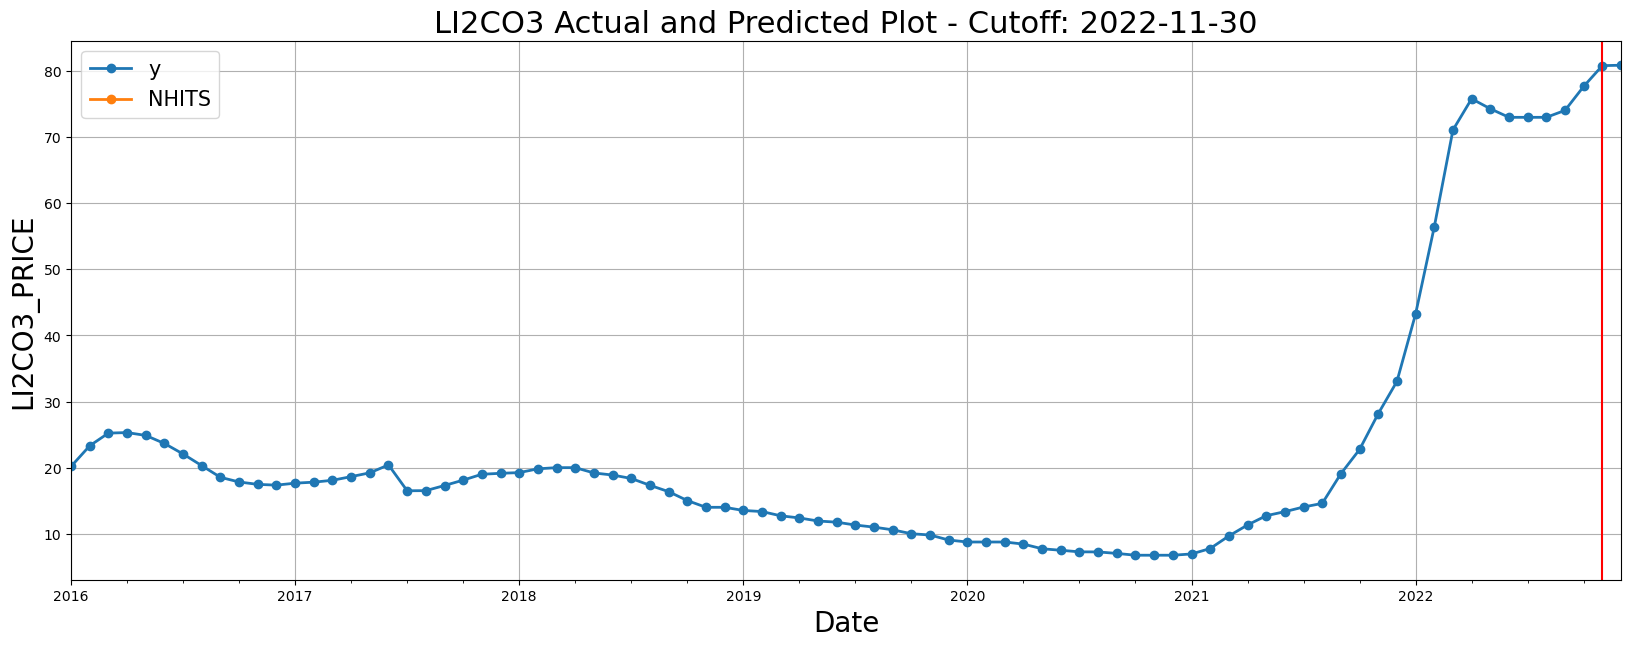

In [113]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

if len(Y_test_df) > 0:
    Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
    # plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
else:
    plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y','NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [111]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)

In [114]:
Y_hat_df

,ds,unique_id,y_x,HOUSECOST_FIN_x,1772.HK(Ganfeng Lithium)_Price_Low_x,1772.HK(Ganfeng Lithium)_Price_Open_x,1772.HK(Ganfeng Lithium)_Price_Close_x,1772.HK(Ganfeng Lithium)_Price_Adj Close_x,1772.HK(Ganfeng Lithium)_Price_High_x,보일러용 후판 Q345R 30mm Xinyu Steel [중국] 현물_x,...,Pilbara Mineral Limited_price_High_y,Pilbara Mineral Limited_price_Low_y,Pilbara Mineral Limited_price_Close_y,Pilbara Mineral Limited_price_Adj Close_y,Allkem Limited (AKE.AX)_price_Open_y,Allkem Limited (AKE.AX)_price_High_y,Allkem Limited (AKE.AX)_price_Low_y,Allkem Limited (AKE.AX)_price_Close_y,Allkem Limited (AKE.AX)_price_Adj Close_y,NHITS
0,2022-12-31,A,80.882353,3.167846,1.03721,1.011836,1.007555,1.024881,0.990812,-0.213492,...,1.967237,1.981728,1.959693,1.857597,2.230517,2.206089,2.211335,2.207568,2.207568,NaN
